Loaded WRF_interp_T_2000-03.nc with Dask chunks
Loaded WRF_interp_QRAIN_2000-03.nc with Dask chunks
Loaded WRF_interp_QSNOW_2000-03.nc with Dask chunks
Loaded WRF_interp_QICE_2000-03.nc with Dask chunks
Loaded WRF_interp_QGRAUP_2000-03.nc with Dask chunks


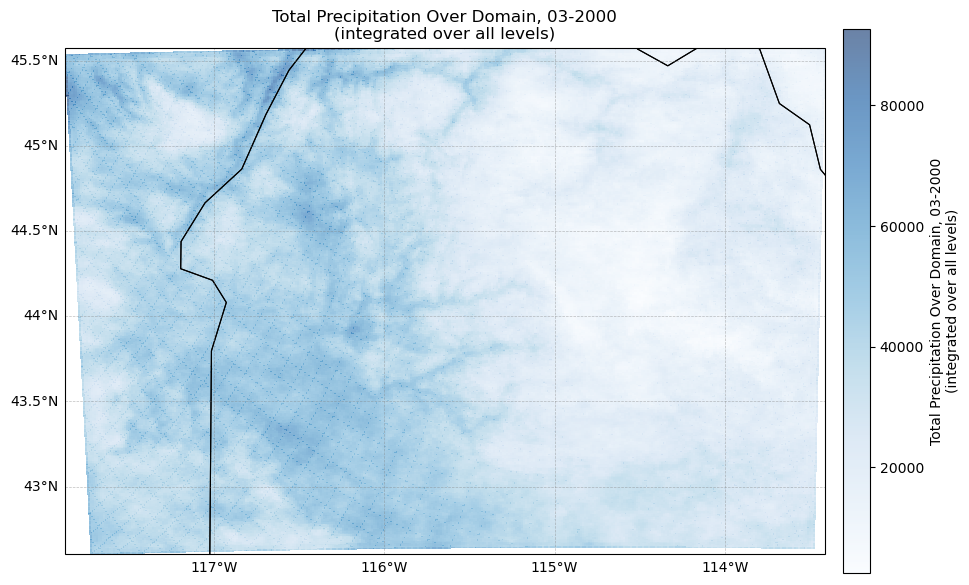

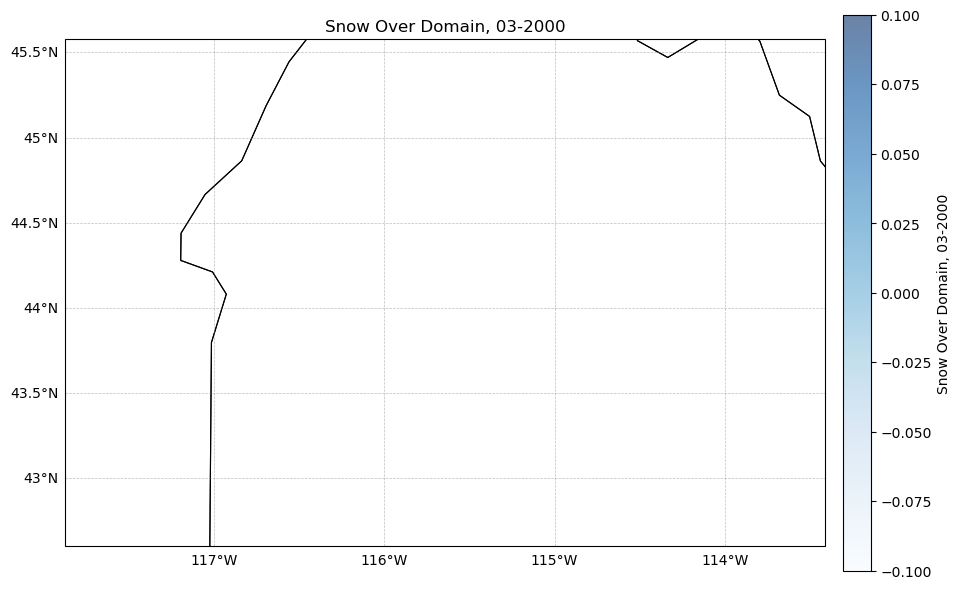

In [4]:
import os
import numpy as np
import dask
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, fix_accum_reset

# === DIRECTORIES ===
# 2-D accumulators live in your d02 directory
d02_dir          = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
# 3-D (interpolated) files if you ever need them
interp3d_dir     = "/bsushare/leaf-shared/subset-output-wrf/lev_interpolated/vol04/wrf_out/wy_2000/d02/"

# === CONFIGURATION ===
month            = "03"
year             = "2000"
target_location  = "Domain"
epsilon          = 1e-6   # to avoid division by zero in fraction
min_precip       = 1.0    # mm, mask threshold

# === LOAD COORDS (from either dataset — they’re the same grid) ===
t2_ds    = load_wrf_var("WRF_T2"      , d02_dir     , year, month)
lats     = t2_ds["XLAT"   ][0].values
lons     = t2_ds["XLONG"  ][0].values

# === LOAD 2-D ACCUMULATORS ===
rain_nc  = load_wrf_var("WRF_RAINNC" , d02_dir     , year, month)
snow_nc  = load_wrf_var("WRF_SNOWNC" , d02_dir     , year, month)
hail_nc  = load_wrf_var("WRF_HAILNC" , d02_dir     , year, month)
graup_nc = load_wrf_var("WRF_GRAUPELNC", d02_dir    , year, month)

# === COMPUTE MONTHLY TOTALS ===
# this returns dask-backed DataArray of shape (south_north, west_east)
rain_total  = fix_accum_reset(rain_nc["RAINNC"])    
snow_total  = snow_nc["SNOWNC"].diff("Time").clip(min=0).sum("Time")
hail_total  = hail_nc["HAILNC"].diff("Time").clip(min=0).sum("Time")
graup_total = graup_nc["GRAUPELNC"].diff("Time").clip(min=0).sum("Time")

# liquid is whatever remains
liquid_total = rain_total - (snow_total + hail_total + graup_total)

# snow fraction at the surface
snow_frac_da = snow_total / (rain_total + epsilon)

# === PULL EVERYTHING INTO MEMORY & AS NUMPY ARRAYS ===
rain2d, snow2d, hail2d, graup2d, liquid2d, frac2d = dask.compute(
    rain_total, snow_total, hail_total, graup_total, liquid_total, snow_frac_da
)
rain2d    = rain2d.values
snow2d    = snow2d.values
hail2d    = hail2d.values
graup2d   = graup2d.values
liquid2d  = liquid2d.values
frac2d    = frac2d.values

# === APPLY MASK (only where total rain < threshold) ===
mask      = rain2d < min_precip
rain_ma   = np.ma.masked_array(rain2d,    mask=mask)
snow_ma   = np.ma.masked_array(snow2d,    mask=mask)
hail_ma   = np.ma.masked_array(hail2d,    mask=mask)
graup_ma  = np.ma.masked_array(graup2d,   mask=mask)
liquid_ma = np.ma.masked_array(liquid2d,  mask=mask)
frac_ma   = np.ma.masked_array(frac2d,    mask=mask)

# === PLOT ===
plot_cartopy(lons, lats, rain_ma,
    f"Total Precipitation Over {target_location}, {month}-{year}", cmap="Blues"
)
plot_cartopy(lons, lats, snow_ma,
    f"Snow Over {target_location}, {month}-{year}", cmap="Blues"
)
plot_cartopy(lons, lats, hail_ma,
    f"Hail Over {target_location}, {month}-{year}", cmap="Blues"
)
plot_cartopy(lons, lats, graup_ma,
    f"Graupel Over {target_location}, {month}-{year}", cmap="Blues"
)
plot_cartopy(lons, lats, liquid_ma,
    f"Liquid Over {target_location}, {month}-{year}", cmap="Blues"
)
plot_cartopy(lons, lats, frac_ma,
    f"Snow Fraction Over {target_location}, {month}-{year}", cmap="viridis", vmin=0, vmax=1
)
